In [1]:
from glob import glob
import os
import pandas as pd

#checnking the input files
print(os.listdir("../input/siim-acr-pneumothorax-segmentation-data"))

#reading all dcm files into train and text
train = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm"))
test = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm"))
print("train files: ", len(train))
print("test files: ", len(test))

pd.reset_option('max_colwidth')

#reading the csv
print("the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax")
masks = pd.read_csv("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv", delimiter=",")
masks.head()

['pneumothorax']
train files:  10712
test files:  1377
the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0020) Patient ID                          LO: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

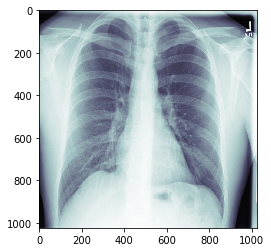

In [2]:
import pydicom
import matplotlib.pyplot as plt

#displaying the image
img = pydicom.read_file(train[0]).pixel_array
plt.imshow(img, cmap='bone')
plt.grid(False)

#displaying metadata
data = pydicom.dcmread(train[0])
print(data)

In [3]:
#dataframe to ease the access
patients = []
missing = 0

pd.reset_option('max_colwidth')

for t in train:
    data = pydicom.dcmread(t)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    try:
        encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
        patient["EncodedPixels"] = encoded_pixels
    except:
        missing = missing + 1
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    patient["path"] = "../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/" + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    patients.append(patient)

print("missing labels: ", missing)
#pd.set_option('display.max_colwidth', -1)
df_patients = pd.DataFrame(patients, columns=["UID", "EncodedPixels", "Age", "Sex", "Modality", "BodyPart", "ViewPosition", "path"])
print("images with labels: ", df_patients.shape[0])
df_patients.head()

missing labels:  37
images with labels:  10712


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,../input/siim-acr-pneumothorax-segmentation-da...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...


5903 4809
8296 2416
4554 1349 3742 1067


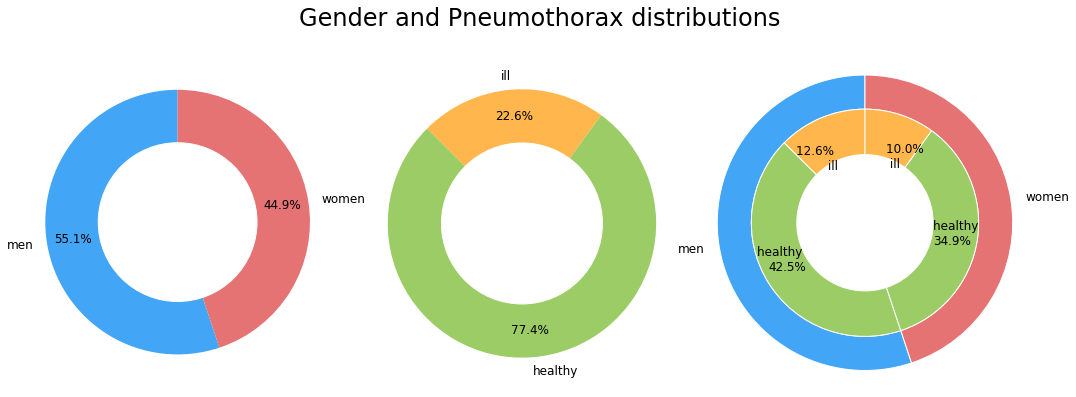

In [4]:
import matplotlib as mpl
import numpy as np

#gender
men = df_patients[df_patients["Sex"] == "M"].shape[0]
women = df_patients.shape[0] - men
print(men, women)


#illness
healthy = df_patients[df_patients["EncodedPixels"] == " -1"].shape[0]
ill = df_patients.shape[0] - healthy
print(healthy, ill)

#gender + illness
men_h = df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] == " -1")].shape[0]
men_ill = men - men_h
women_h = df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] == " -1")].shape[0]
women_ill = women - women_h
print(men_h, men_ill, women_h, women_ill)

perc = [str(round(men_ill/107.12, 1)) + "% \n ill", "healthy \n" + str(round(men_h/107.12, 1)) + "%", "healthy \n" + str(round(women_h/107.12, 1)) + "%",str(round(women_ill/107.12, 1)) + "% \n ill"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Gender and Pneumothorax distributions", fontsize=24, y=1.1)

mpl.rcParams['font.size'] = 12.0

#circle for donut chart
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
circle1 = plt.Circle( (0,0), 0.4, color = 'white')
circle2 = plt.Circle( (0,0), 0.6, color = 'white')

#men women
ax[0].pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax[0].add_patch(circle0)
ax[0].axis('equal')

#gender healthy
mypie, _ = ax[2].pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')

mypie2, _ = ax[2].pie([ men_ill, men_h, women_h, women_ill], radius = 1.3 - 0.3, labels=perc, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

#healthy ill
ax[1].pie([healthy, ill], labels=["healthy", "ill"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%', pctdistance=0.8, startangle=135)
ax[1].add_patch(circle2)
ax[1].axis('equal')  

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
#group into bins the same aged men and women with histogram --> all of them and ill of them

#convert he Age column to int
df_patients["Age"] = pd.to_numeric(df_patients["Age"])

sorted_ages = np.sort(df_patients["Age"].values)
print(sorted_ages)

[  1   2   2 ...  94 148 413]


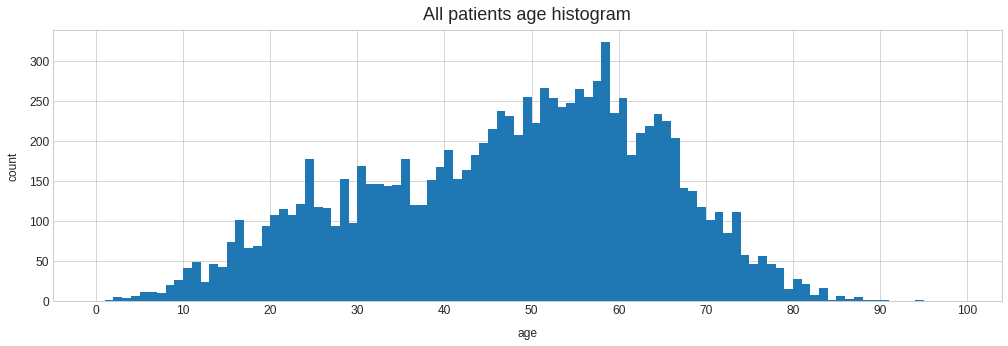

In [6]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(17, 5))
plt.hist(sorted_ages[:-2], bins=[i for i in range(100)])
plt.title("All patients age histogram", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(11)])
plt.ylabel("count", labelpad=10)
plt.show()

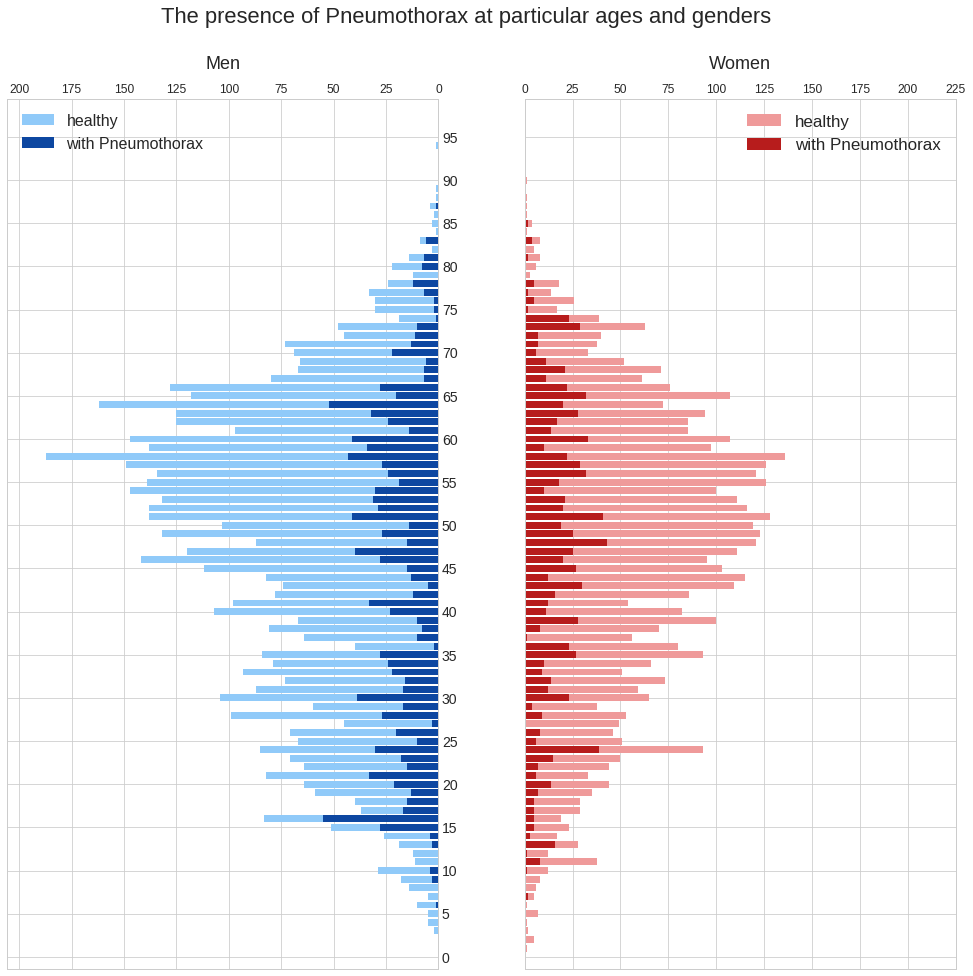

In [7]:
#calculating all and ill men and women histograms
bins = [i for i in range(100)]
plt.style.use('seaborn-whitegrid')

all_men = np.histogram(df_patients[df_patients["Sex"] == "M"]["Age"].values, bins=bins)[0]
all_women = np.histogram(df_patients[df_patients["Sex"] == "F"]["Age"].values, bins=bins)[0]

ill_men = np.histogram(df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] != ' -1')]["Age"].values, bins=bins)[0]
ill_women = np.histogram(df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] != ' -1')]["Age"].values, bins=bins)[0]

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(17, 16))

fig.suptitle("The presence of Pneumothorax at particular ages and genders", fontsize=22, y=0.96)

axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Men', fontsize=18, pad=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('healthy', 'with Pneumothorax'), loc=2, prop={'size': 16})

locs = axes[0].get_xticks()

axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Women', fontsize=18, pad=15)
axes[1].xaxis.tick_top()
axes[1].set_xticks(locs)
axes[1].legend((w1[0], w2[0]), ('healthy', 'with Pneumothorax'), prop={'size': 17})

#for i, v in enumerate(depos["ItemViewCount"].values):
   #print(i, v)
    #axes[1].text(int(v) + 3, int(i)-0.25, str(v))
plt.show()

In [8]:
bodypart = df_patients["BodyPart"].values
print("Body parts:", list(set(bodypart)))

modality = df_patients["Modality"].values
print("Modality:", list(set(modality)))

view = list(df_patients["ViewPosition"].values)
print("View Positions: ", list(set(view)))

pa = view.count("PA")
ap = view.count("AP")
print(pa, ap)

Body parts: ['CHEST']
Modality: ['CR']
View Positions:  ['AP', 'PA']
6507 4205


Text(0.5, 1.0, 'Occurrences of View positions')

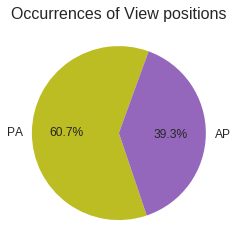

In [9]:

basic_palette = sns.color_palette()
plt.style.use('seaborn-whitegrid')
plt.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
plt.title("Occurrences of View positions", fontsize=16)

to be continued